In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 40000 # int(sys.argv[1])  # number of training steps
iteration = 5 # int(sys.argv[2])  # number of iterations (iid runs)
d = 4 # int(sys.argv[3])  # dimension of the distributions
mb_size = 4000 # int(sys.argv[4])  # batch size
N = 50000
rho_range = [0.1, 0.3, 0.5, 0.7, 0.9]
lam_gp = 0.1  # gradient penalty constant: \lambda_{gp}

print(steps)
print(iteration)
print(d)
print(mb_size)
print(N)


40000
5
4
4000
50000


In [3]:
# hyperparameters
if d==4:
    layers = [d, 8, 8, 4, 1]
elif d==20:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 32, 32, 16, 1] # [d, 64, 64, 32, 1]
else:                      
    print('check dimension!')

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    #out = 50.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 50.0) # bound M = 50
    #out = 20.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 20.0)
    out =  tf.add(tf.matmul(h, W), b)   # unbounded!
    
    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(rho_range), iteration))
RD_exact_rho =  np.zeros(shape= len(rho_range))


In [6]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, rho in enumerate(rho_range): 
    
    print('j=', j)
    print('rho=', rho)
    
    # load data
    #fname = 'data/mu2_1_arch_16/N'+str(n)+'_a_0.5_and_3.7/input_data/GMM_d_1_'
    fname = 'data/varying_rho_Sigma1_eye_2/d_4/input_N50000_dim4/gaussian_d_' + str(d) + '_'
    data = scipy.io.loadmat(fname + 'data_'+str(rho)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(rho)+'.mat')
    alpha = np.array(params['alpha'])
    No_alpha = alpha.shape[0]

    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas. In current datafiles, only one

    
    beta = lam*(1-alpha[0])  #   <----------- choose the first alpha value
    gamma = lam*alpha[0]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_rho[j] = RD_exact[0];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake

    # Gradient Penalty
    alpha_gp = tf.random_uniform(shape=[mb_size,1], minval=0., maxval=1.)
    interpolates = X + (alpha_gp*(Y - X)) 
    gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]  
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean(tf.math.maximum(tf.zeros([slopes.shape[0]], dtype=tf.float32) ,(slopes-5.))**2)  # Lipschitz with K=5 

    total_loss = D_loss + lam_gp*gradient_penalty
    
    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_gaussian_Lip_plots/'):
        os.makedirs('data/out_gaussian_Lip_plots/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_gaussian_Lip_plots/cgan_Dloss' + str(j) + 'rho_' + str(rho) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
rho= 0.1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration: 0
Iter: 0
Renyi divergence: [7.025432e-06]

Iter: 1000
Renyi divergence: [0.00582385]

Iter: 2000
Renyi divergence: [0.01254576]

Iter: 3000
Renyi divergence: [0.01297206]

Iter: 4000
Renyi divergence: [0.01063567]

Iter: 5000
Renyi divergence: [0.00724161]

Iter: 6000
Renyi divergence: [0.01240122]

Iter: 7000
Renyi divergence: [0.01154816]

Iter: 8000
Renyi divergence: [0.00214267]

Iter: 9000
Renyi divergence: [0.01361859]

Iter: 10000
Renyi divergence: [0.00560093]

Iter: 11000
Renyi divergence: [0.01725996]

Iter: 12000
Renyi divergence: [0.0122124]

Iter: 13000
Renyi divergence: [0.00884867]

Iter: 14000
Renyi divergence: [0.01248002]

Iter: 15000
Renyi divergence: [0.00950825]

Iter: 16000
Renyi divergence: [0.0127424]

Iter: 17000
Renyi divergence: [0.01528144]

Iter: 18000
Renyi divergence: [0.00798833]

Iter: 19000
Renyi divergence: [0.01466787]

Iter: 20000


Iter: 19000
Renyi divergence: [0.01849574]

Iter: 20000
Renyi divergence: [0.01202935]

Iter: 21000
Renyi divergence: [0.01125932]

Iter: 22000
Renyi divergence: [0.01798636]

Iter: 23000
Renyi divergence: [0.01620936]

Iter: 24000
Renyi divergence: [0.0097304]

Iter: 25000
Renyi divergence: [0.01151502]

Iter: 26000
Renyi divergence: [0.01300502]

Iter: 27000
Renyi divergence: [0.01370245]

Iter: 28000
Renyi divergence: [0.01194549]

Iter: 29000
Renyi divergence: [0.0179314]

Iter: 30000
Renyi divergence: [0.01517618]

Iter: 31000
Renyi divergence: [0.01551408]

Iter: 32000
Renyi divergence: [0.01119447]

Iter: 33000
Renyi divergence: [0.01562792]

Iter: 34000
Renyi divergence: [0.01555842]

Iter: 35000
Renyi divergence: [0.01791823]

Iter: 36000
Renyi divergence: [0.01674145]

Iter: 37000
Renyi divergence: [0.0136767]

Iter: 38000
Renyi divergence: [0.01602179]

Iter: 39000
Renyi divergence: [0.01913321]

j= 1
rho= 0.3
Iteration: 0
Iter: 0
Renyi divergence: [1.1524098e-06]

Iter: 100

Iter: 5000
Renyi divergence: [0.11394882]

Iter: 6000
Renyi divergence: [0.08942056]

Iter: 7000
Renyi divergence: [0.091717]

Iter: 8000
Renyi divergence: [0.09524727]

Iter: 9000
Renyi divergence: [0.0825696]

Iter: 10000
Renyi divergence: [0.12708235]

Iter: 11000
Renyi divergence: [0.10113966]

Iter: 12000
Renyi divergence: [0.09913957]

Iter: 13000
Renyi divergence: [0.11128652]

Iter: 14000
Renyi divergence: [0.10863471]

Iter: 15000
Renyi divergence: [0.09472656]

Iter: 16000
Renyi divergence: [0.10912466]

Iter: 17000
Renyi divergence: [0.11465526]

Iter: 18000
Renyi divergence: [0.11464524]

Iter: 19000
Renyi divergence: [0.09798169]

Iter: 20000
Renyi divergence: [0.11955857]

Iter: 21000
Renyi divergence: [0.10785007]

Iter: 22000
Renyi divergence: [0.10067606]

Iter: 23000
Renyi divergence: [0.12595034]

Iter: 24000
Renyi divergence: [0.12189937]

Iter: 25000
Renyi divergence: [0.11272192]

Iter: 26000
Renyi divergence: [0.11612201]

Iter: 27000
Renyi divergence: [0.1082136

Iter: 33000
Renyi divergence: [0.30359912]

Iter: 34000
Renyi divergence: [0.36846638]

Iter: 35000
Renyi divergence: [0.3178892]

Iter: 36000
Renyi divergence: [0.30609632]

Iter: 37000
Renyi divergence: [0.3150797]

Iter: 38000
Renyi divergence: [0.34482288]

Iter: 39000
Renyi divergence: [0.33094788]

Iteration: 4
Iter: 0
Renyi divergence: [1.0886695e-05]

Iter: 1000
Renyi divergence: [0.0629319]

Iter: 2000
Renyi divergence: [0.08681107]

Iter: 3000
Renyi divergence: [0.3035257]

Iter: 4000
Renyi divergence: [0.32592297]

Iter: 5000
Renyi divergence: [0.30962515]

Iter: 6000
Renyi divergence: [0.35979128]

Iter: 7000
Renyi divergence: [0.29768443]

Iter: 8000
Renyi divergence: [0.33833575]

Iter: 9000
Renyi divergence: [0.3112588]

Iter: 10000
Renyi divergence: [0.34396553]

Iter: 11000
Renyi divergence: [0.3533287]

Iter: 12000
Renyi divergence: [0.3078966]

Iter: 13000
Renyi divergence: [0.30496097]

Iter: 14000
Renyi divergence: [0.3163743]

Iter: 15000
Renyi divergence: [0.3208

Iter: 21000
Renyi divergence: [0.8396933]

Iter: 22000
Renyi divergence: [0.8285241]

Iter: 23000
Renyi divergence: [0.80549455]

Iter: 24000
Renyi divergence: [0.8528757]

Iter: 25000
Renyi divergence: [0.8899162]

Iter: 26000
Renyi divergence: [0.89065933]

Iter: 27000
Renyi divergence: [0.8140199]

Iter: 28000
Renyi divergence: [0.7962804]

Iter: 29000
Renyi divergence: [0.82252955]

Iter: 30000
Renyi divergence: [0.809005]

Iter: 31000
Renyi divergence: [0.8473985]

Iter: 32000
Renyi divergence: [0.8011317]

Iter: 33000
Renyi divergence: [0.8541417]

Iter: 34000
Renyi divergence: [0.8253393]

Iter: 35000
Renyi divergence: [0.88838553]

Iter: 36000
Renyi divergence: [0.81022]

Iter: 37000
Renyi divergence: [0.84670067]

Iter: 38000
Renyi divergence: [0.8446727]

Iter: 39000
Renyi divergence: [0.873878]

Iteration: 4
Iter: 0
Renyi divergence: [1.118728e-05]

Iter: 1000
Renyi divergence: [0.3842379]

Iter: 2000
Renyi divergence: [0.7930441]

Iter: 3000
Renyi divergence: [0.8012328]

I

Iter: 12000
Renyi divergence: [2.34276]

Iter: 13000
Renyi divergence: [2.3699756]

Iter: 14000
Renyi divergence: [2.2595928]

Iter: 15000
Renyi divergence: [2.2500057]

Iter: 16000
Renyi divergence: [2.3299026]

Iter: 17000
Renyi divergence: [2.375875]

Iter: 18000
Renyi divergence: [2.3793592]

Iter: 19000
Renyi divergence: [2.2781894]

Iter: 20000
Renyi divergence: [2.3405218]

Iter: 21000
Renyi divergence: [2.2944732]

Iter: 22000
Renyi divergence: [2.3382022]

Iter: 23000
Renyi divergence: [2.3345528]

Iter: 24000
Renyi divergence: [2.280432]

Iter: 25000
Renyi divergence: [2.318523]

Iter: 26000
Renyi divergence: [2.3279521]

Iter: 27000
Renyi divergence: [2.3730862]

Iter: 28000
Renyi divergence: [2.2759552]

Iter: 29000
Renyi divergence: [2.3779044]

Iter: 30000
Renyi divergence: [2.332768]

Iter: 31000
Renyi divergence: [2.3808708]

Iter: 32000
Renyi divergence: [2.2803547]

Iter: 33000
Renyi divergence: [2.2839246]

Iter: 34000
Renyi divergence: [2.4307628]

Iter: 35000
Renyi

In [7]:
print(D_loss_vals)

[[0.01316452 0.01642615 0.01212108 0.01267064 0.01483428]
 [0.10958934 0.10123944 0.1087451  0.10513675 0.10603738]
 [0.32959485 0.32815504 0.32915521 0.33387613 0.32756639]
 [0.82497454 0.79857349 0.81894445 0.8355391  0.82612658]
 [2.35729146 2.34316635 2.32826614 2.3290019  2.34643507]]


In [11]:
   

with open('data/out_gaussian_Lip_plots/'+'lambda_'+str(lam)+ '_gp_' + str(lam_gp)+'_bs_'+str(mb_size)+'_nerd_'+str(rho)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


Text(0, 0.5, 'divergence')

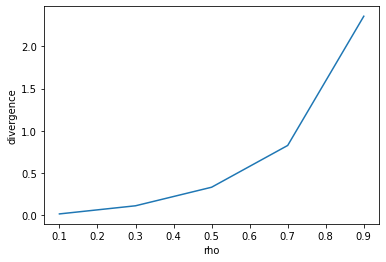

In [9]:
# Plot RD vs rho
#======================
fig = plt.figure()
plt.plot(rho_range, D_loss_vals[:,0])
plt.xlabel('rho')
plt.ylabel('divergence')

(0.0, 3.0)

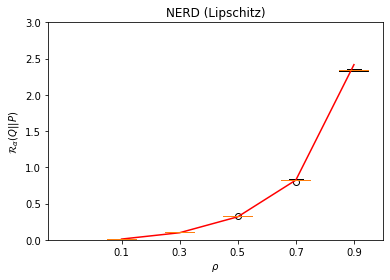

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Lipschitz)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.3, 0.5, 0.7, 0.9], whis=2)
ax1.plot(np.arange(1,len(rho_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 3.0)




In [ ]:
print('program terminated succesfully')